## Designing an Open Channel: Determining Optimal Width and Depth While Satisfying Velocity Constraints Across Varying Flow Rates

Rectangular Channel Design:
width_mm: 139
total_depth_mm: 107
velocity_mps: 0.7761
flow_area_m2: 0.0129
hydraulic_radius_m: 0.0397
depth_m: 0.0927
channel_shape: rectangular


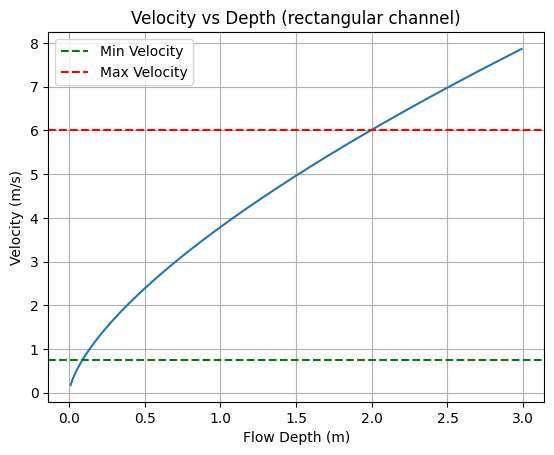


Trapezoidal Channel Design:
width_mm: 128
total_depth_mm: 98
velocity_mps: 0.9088
flow_area_m2: 0.022
hydraulic_radius_m: 0.0503
depth_m: 0.0857
channel_shape: trapezoidal


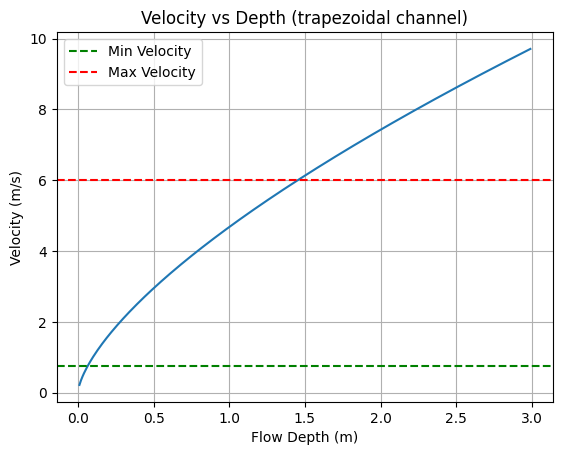

In [1]:
import math
import matplotlib.pyplot as plt
from scipy.optimize import brentq


class OpenChannelDesigner:
    def __init__(self, peak_discharge, mannings_n=0.015, slope=0.01,
                 min_velocity=0.75, max_velocity=6, freeboard_percent=0.15):
        self.Q = peak_discharge
        self.n = mannings_n
        self.S = slope
        self.v_min = min_velocity
        self.v_max = max_velocity
        self.freeboard_percent = freeboard_percent

    def _calculate_flow(self, y, b, side_slope=0):
        """Calculates discharge, area, perimeter, and velocity for given depth."""
        if side_slope == 0:  # Rectangular
            area = b * y
            perimeter = b + 2 * y
        else:  # Trapezoidal
            top_width = b + 2 * side_slope * y
            area = (b + side_slope * y) * y
            perimeter = b + 2 * y * math.sqrt(1 + side_slope ** 2)

        R = area / perimeter
        Q_calc = (1 / self.n) * area * R ** (2 / 3) * self.S ** 0.5
        velocity = Q_calc / area
        return Q_calc, area, velocity, R

    def design_channel(self, b_y_ratio=1.0, shape='rectangular', side_slope=0):
        def objective(y):
            b = b_y_ratio * y
            Q_calc, area, velocity, _ = self._calculate_flow(y, b, side_slope)
            return Q_calc - self.Q

        try:
            # Solve using Brent's method
            y_solution = brentq(objective, 1e-4, 5.0)
            b = b_y_ratio * y_solution
            Q_calc, area, velocity, R = self._calculate_flow(y_solution, b, side_slope)

            if not (self.v_min <= velocity <= self.v_max):
                return None

            freeboard = y_solution * self.freeboard_percent
            total_depth = y_solution + freeboard
            return {
                "width_mm": round(b * 1000),
                "total_depth_mm": round(total_depth * 1000),
                "velocity_mps": round(velocity, 4),
                "flow_area_m2": round(area, 4),
                "hydraulic_radius_m": round(R, 4),
                "depth_m": round(y_solution, 4),
                "channel_shape": shape
            }

        except ValueError:
            return None

    def plot_velocity_profile(self, b_y_ratio=1.0, shape='rectangular', side_slope=0):
        depths = [i / 100 for i in range(1, 300)]
        velocities = []
        for y in depths:
            b = b_y_ratio * y
            _, area, v, _ = self._calculate_flow(y, b, side_slope)
            velocities.append(v)
        plt.plot(depths, velocities)
        plt.axhline(self.v_min, color='green', linestyle='--', label='Min Velocity')
        plt.axhline(self.v_max, color='red', linestyle='--', label='Max Velocity')
        plt.xlabel("Flow Depth (m)")
        plt.ylabel("Velocity (m/s)")
        plt.title(f"Velocity vs Depth ({shape} channel)")
        plt.legend()
        plt.grid(True)
        plt.show()


# === USAGE EXAMPLES ===

designer = OpenChannelDesigner(peak_discharge=0.01)  # 10 L/s
result_rect = designer.design_channel(b_y_ratio=1.5, shape='rectangular')

if result_rect:
    print("Rectangular Channel Design:")
    for key, val in result_rect.items():
        print(f"{key}: {val}")
else:
    print("No valid rectangular channel design found.")

designer.plot_velocity_profile(b_y_ratio=1.5, shape='rectangular')


# Trapezoidal example
designer2 = OpenChannelDesigner(peak_discharge=0.02)  # 20 L/s
result_trap = designer2.design_channel(b_y_ratio=1.5, shape='trapezoidal', side_slope=1.5)

if result_trap:
    print("\nTrapezoidal Channel Design:")
    for key, val in result_trap.items():
        print(f"{key}: {val}")
else:
    print("No valid trapezoidal channel design found.")

designer2.plot_velocity_profile(b_y_ratio=1.5, shape='trapezoidal', side_slope=1.5)